# Insights
It is important to understand how each component in the solver behaves to properly set up the configuration space and identify weak parts of the solver that should not be used. This notebook serves this purpose.

In [1]:
from CVRPSolver import solve, generate_initial_solution, DEFAULT_CONFIG, dp, dijkstra, brute_force, ACO
from CVRPSolver.TSP.TSP import reoptimize_routes
from CVRPSolver.CVRP.heuristics import (
    Tabu,
    destroy_worst,
    destroy_random,
    destroy_shaw_worst, 
    destroy_shaw_random,
    destroy_shaw_removal_route,
    destroy_crossed_lines,
    destroy_random_route,
    repair_best,
    repair_random,
    repair_regret,
    repair_farthest,
    repair_best_2
)

In [2]:
from random import randint, seed
from math import dist
import matplotlib.pyplot as plt
import time
import json


SEED = 0
seed(SEED)

In [3]:
def plot(canvas, locations, a, b):
    def plot_routes(ax, routes, title):
        def plot_route(route):
            x = [locations[loc][0] for loc in route]
            y = [locations[loc][1] for loc in route]
            ax.plot(x, y, marker='o', linestyle='-', color='b')

        for route in routes:
            plot_route(route)

        ax.set_xticks([])
        ax.set_yticks([])
        depot = locations[0]
        ax.scatter(*depot, color='r', s=100, marker='o', zorder=10)
        x = [loc[0] for loc in locations]
        y = [loc[1] for loc in locations]
        ax.scatter(x, y, color='b', marker='o')
        ax.set_title(title)

    _, axs = plt.subplots(a, b, figsize=(16, 9))
    try:
        axs = axs.flatten()
    except:
        axs = [axs]

    for ax, (title, routes) in zip(axs, canvas.items()):
        plot_routes(ax, routes, title)

    plt.tight_layout()
    plt.show()

# CVRP generation

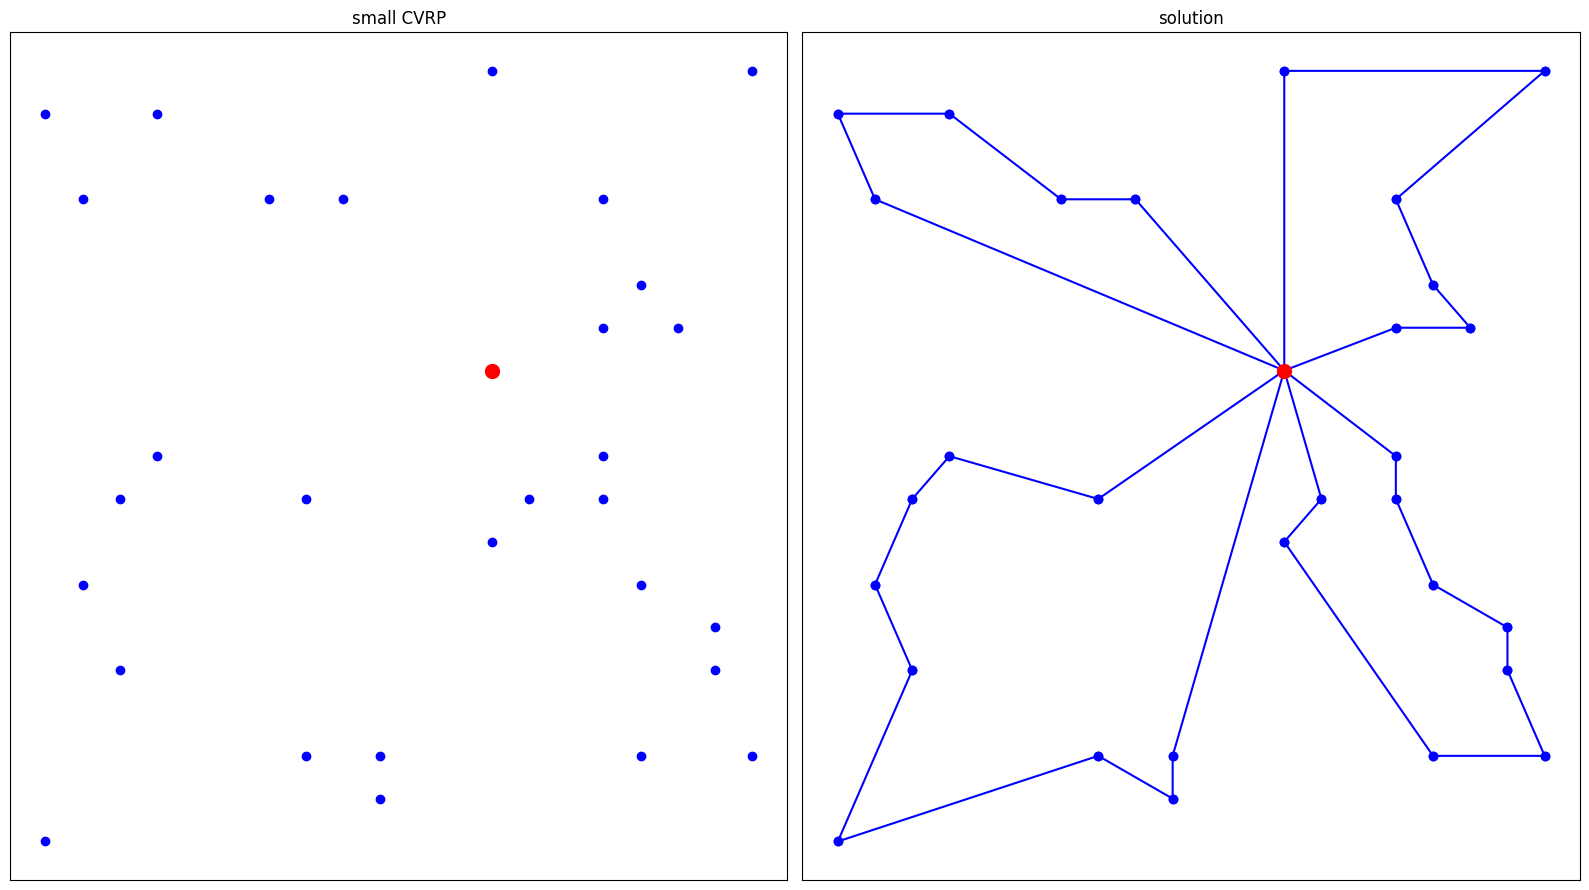

In [4]:
number_of_locations = 30
number_of_vehicles = 5
vehicle_capacity = 100

locations = [(randint(0, 20), randint(0, 20)) for _ in range(number_of_locations)]
distance_matrix = [
    [dist(locations[i], locations[j]) for i in range(number_of_locations)]
    for j in range(number_of_locations)
]

demands = [
    randint(0, 3 * vehicle_capacity * number_of_vehicles // (2 * number_of_locations))
    for _ in range(number_of_locations)
]

sol = solve(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, {"TIME_LIMIT": 5, "SEED": SEED, "TRIES": 1})
plot({"small CVRP": [], "solution": [[0] + route + [0] for route in sol]}, locations, 1, 2)

# Initial solutions

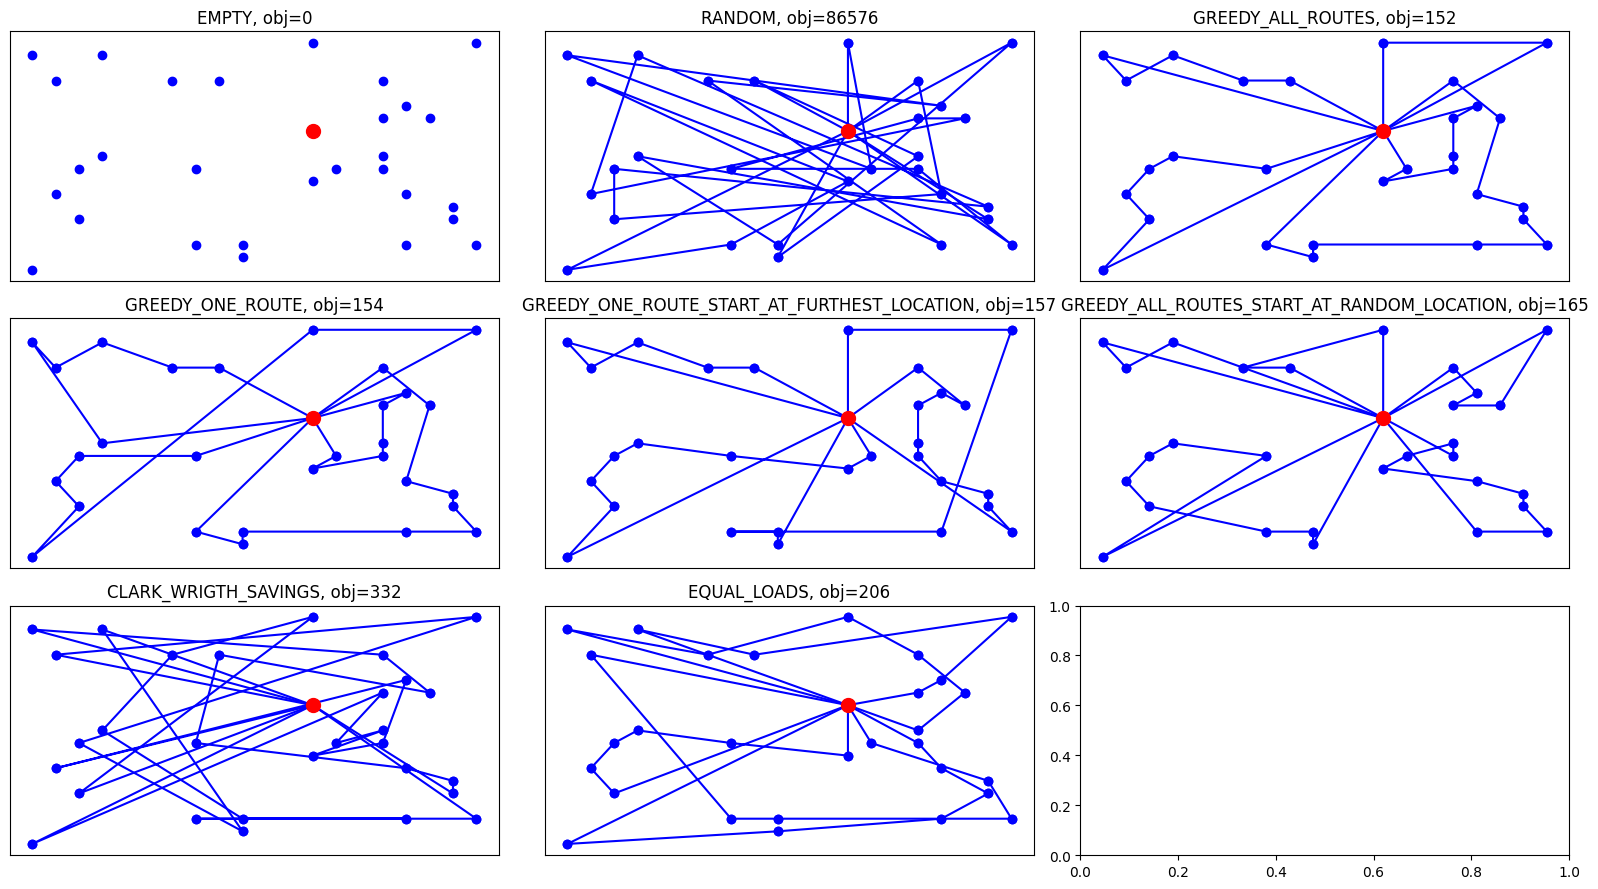

In [5]:
INITIAL_STRATEGIES = [
    "EMPTY", 
    "RANDOM", 
    "GREEDY_ALL_ROUTES", 
    "GREEDY_ONE_ROUTE", 
    "GREEDY_ONE_ROUTE_START_AT_FURTHEST_LOCATION", 
    "GREEDY_ALL_ROUTES_START_AT_RANDOM_LOCATION", 
    "CLARK_WRIGTH_SAVINGS", 
    "EQUAL_LOADS"
]
canvas = {}
for strategy in INITIAL_STRATEGIES:
    sol = generate_initial_solution(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, strategy)
    canvas[f"{strategy}, obj={sol.objective():.0f}"] = [[0]+route+[0] for route in sol]
plot(canvas, locations, 3, 3)

# GREEDY_ALL_ROUTES_RANDOMIZED
parameter temperature determines how much randomness is going to be in the solution
- GREEDY_ALL_ROUTES_RANDOMIZED with small temperature ~ RANDOM
- GREEDY_ALL_ROUTES_RANDOMIZED with high temperature ~ GREEDY_ALL_ROUTES
> Your intuition probably suggests otherwise - you are correct, it should be the other way. However, I had some issues with overflows and numerical stability and this is how I solved it.

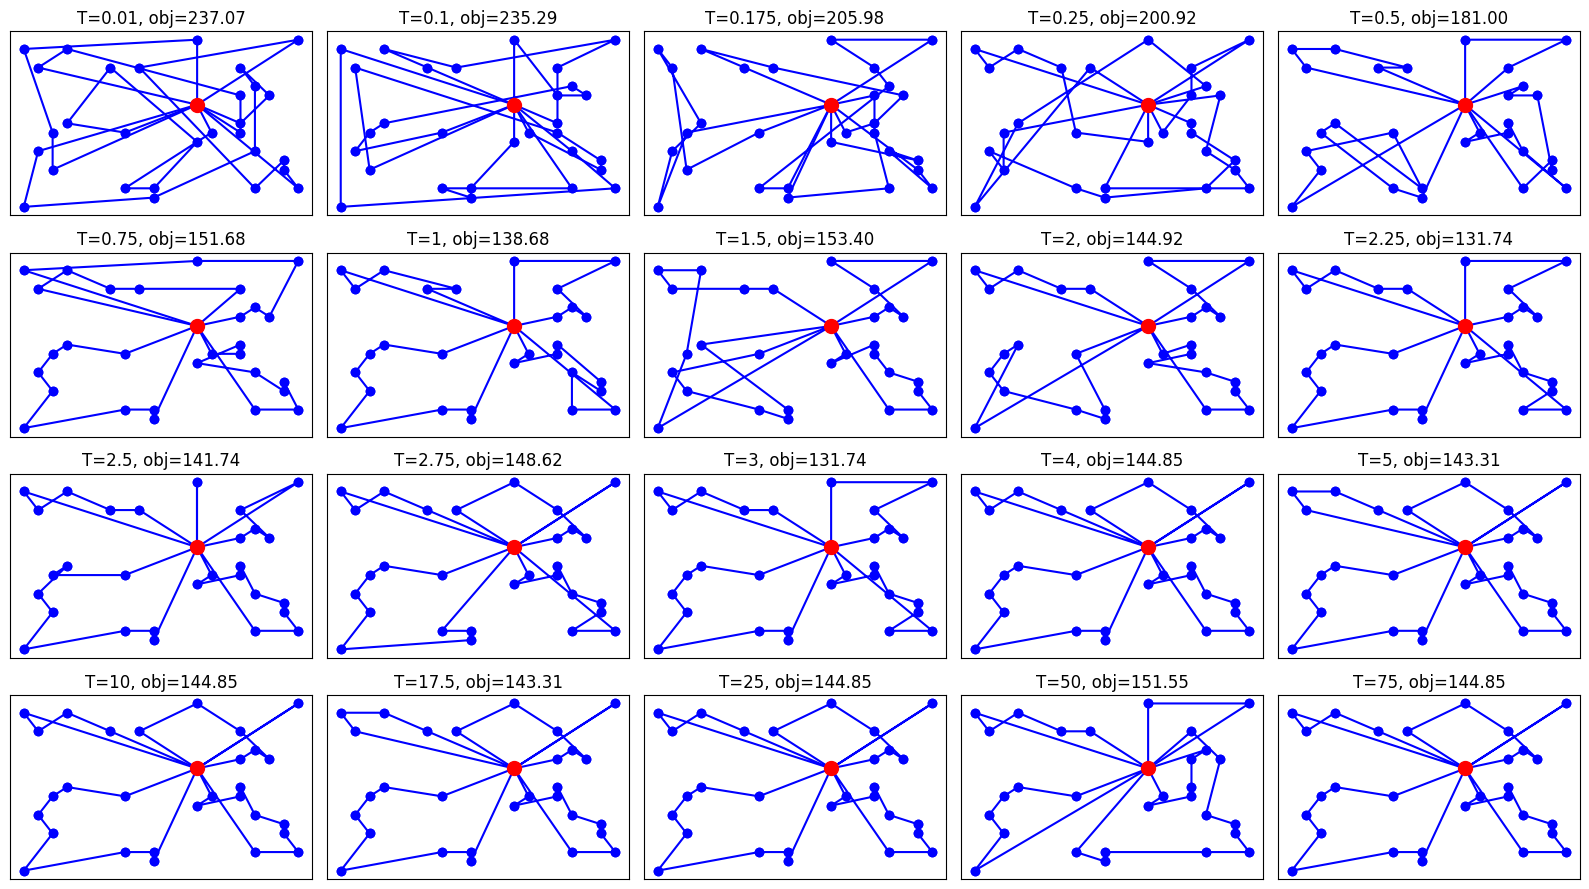

In [6]:
canvas = {}
for T in (0.01, 0.1, 0.175, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.25, 2.5, 2.75, 3, 4, 5, 10, 17.5, 25, 50, 75, 100):
    try:
        sol = generate_initial_solution(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, "GREEDY_ALL_ROUTES_RANDOMIZED", T=T)
        reoptimize_routes(sol, time.time()+5, conf=DEFAULT_CONFIG)
        canvas[f"T={T}, obj={sol.objective():.2f}"] = [[0]+route+[0] for route in sol]
    except Exception as e:
        pass
plot(canvas, locations, 4, 5)

# Heuristics

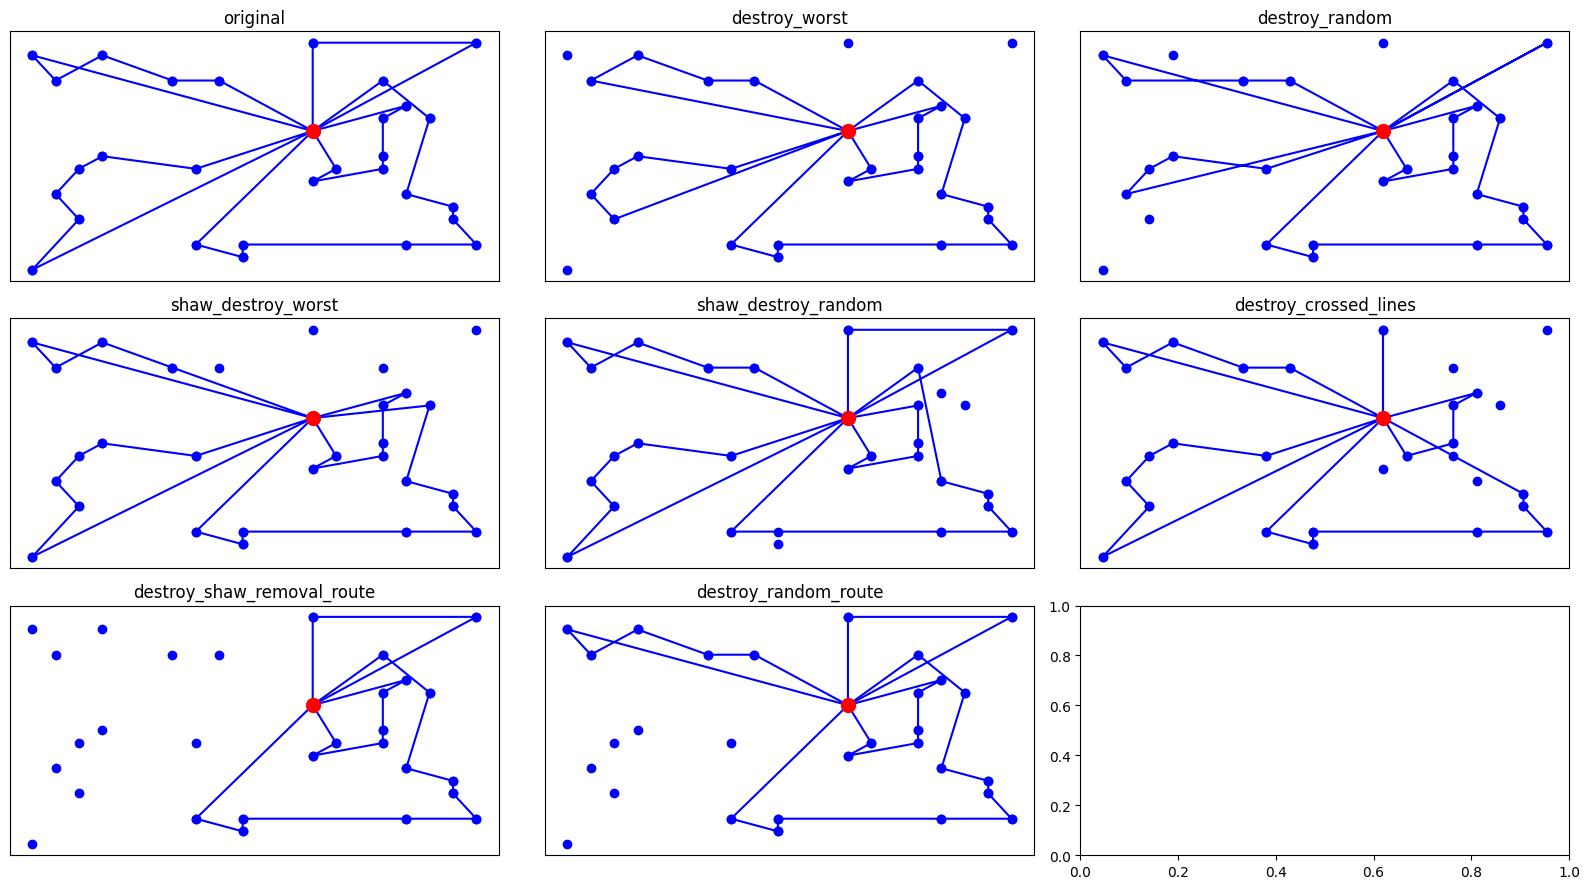

In [7]:
DESTROY = [
    (destroy_worst, 4),
    (destroy_random, 4),
    (destroy_shaw_worst, 2), 
    (destroy_shaw_random, 2),
    (destroy_crossed_lines, 2),
    (destroy_shaw_removal_route, 1),
    (destroy_random_route, 1),
]
canvas = {}
sol = generate_initial_solution(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, "GREEDY_ALL_ROUTES")
canvas["original"] = [[0]+route+[0] for route in sol]
for heuristic, calls in DESTROY:
    cpy = sol.copy()
    Tabu.init(1)
    for _ in range(calls):
        heuristic(cpy)
    
    name = str(heuristic).split()[1] if str(heuristic)[0] == "<" else "shaw_" + str(heuristic).split()[5]
    canvas[name] = [[0]+route+[0] for route in cpy]

plot(canvas, locations, 3, 3)

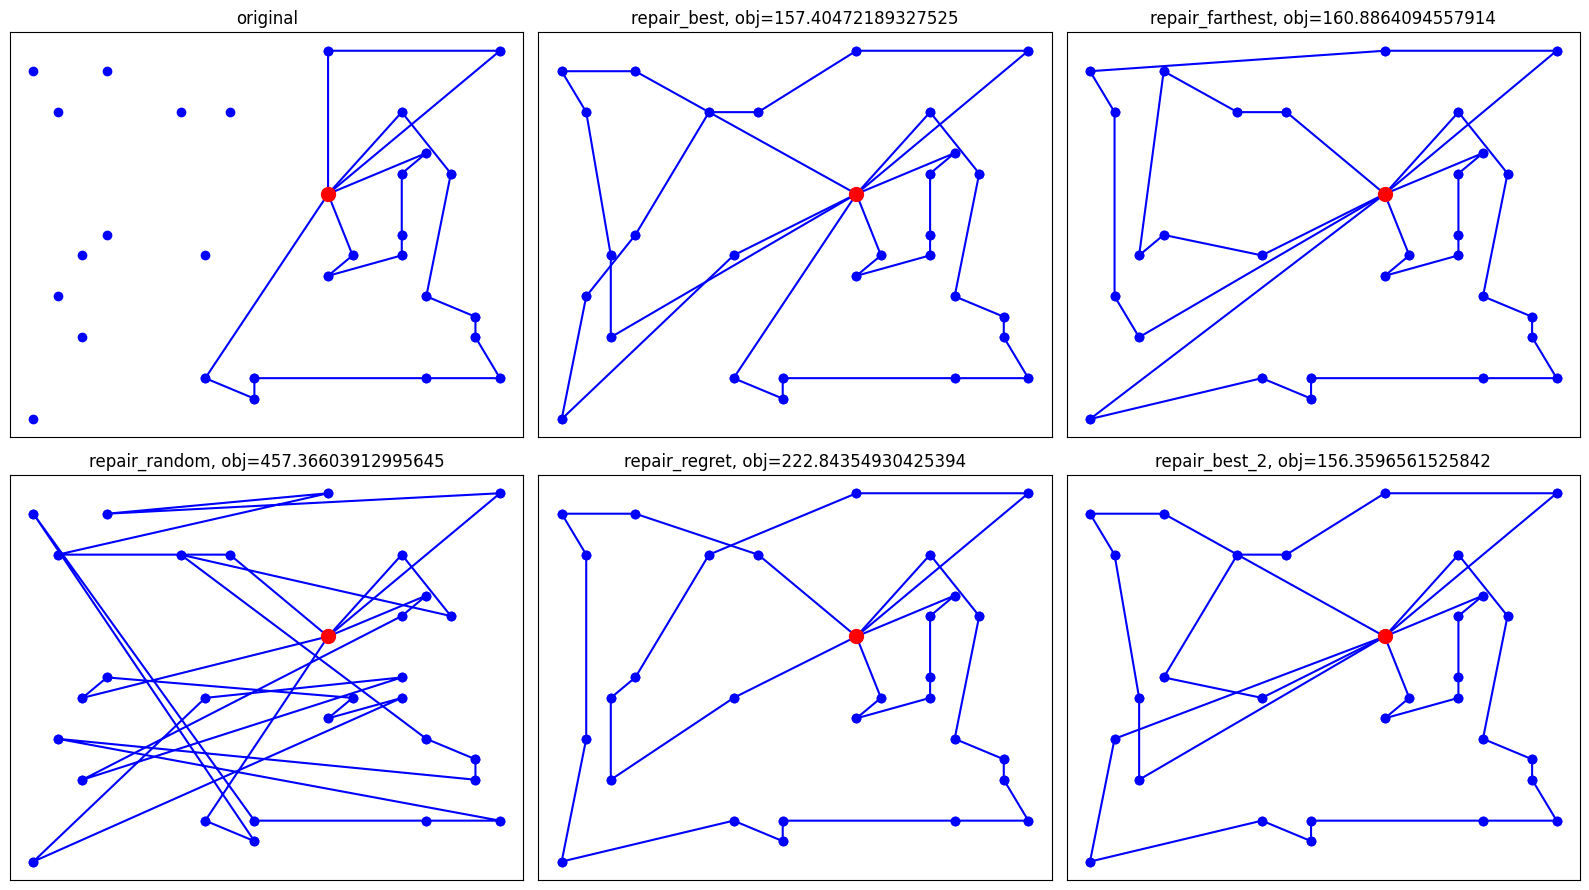

In [8]:
REPAIR = [
    repair_best,
    repair_farthest,
    repair_random,
    repair_regret,
    repair_best_2
]
canvas = {}
sol = generate_initial_solution(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, "GREEDY_ALL_ROUTES")
Tabu.init(1)
destroy_shaw_removal_route(sol)
canvas["original"] = [[0]+route+[0] for route in sol]
for heuristic in REPAIR:
    cpy = sol.copy()
    while cpy.unassigned:
        heuristic(cpy, 45)
    name = str(heuristic).split()[1]
    canvas[f"{name}, obj={cpy.objective()}"] = [[0]+route+[0] for route in cpy]

plot(canvas, locations, 2, 3)

# TSP
## small TSP instances
dp, dijkstra and brute_force should always find the optimal solution, the difference should be only in speed, I have measured them in `other.test_TSP.py`

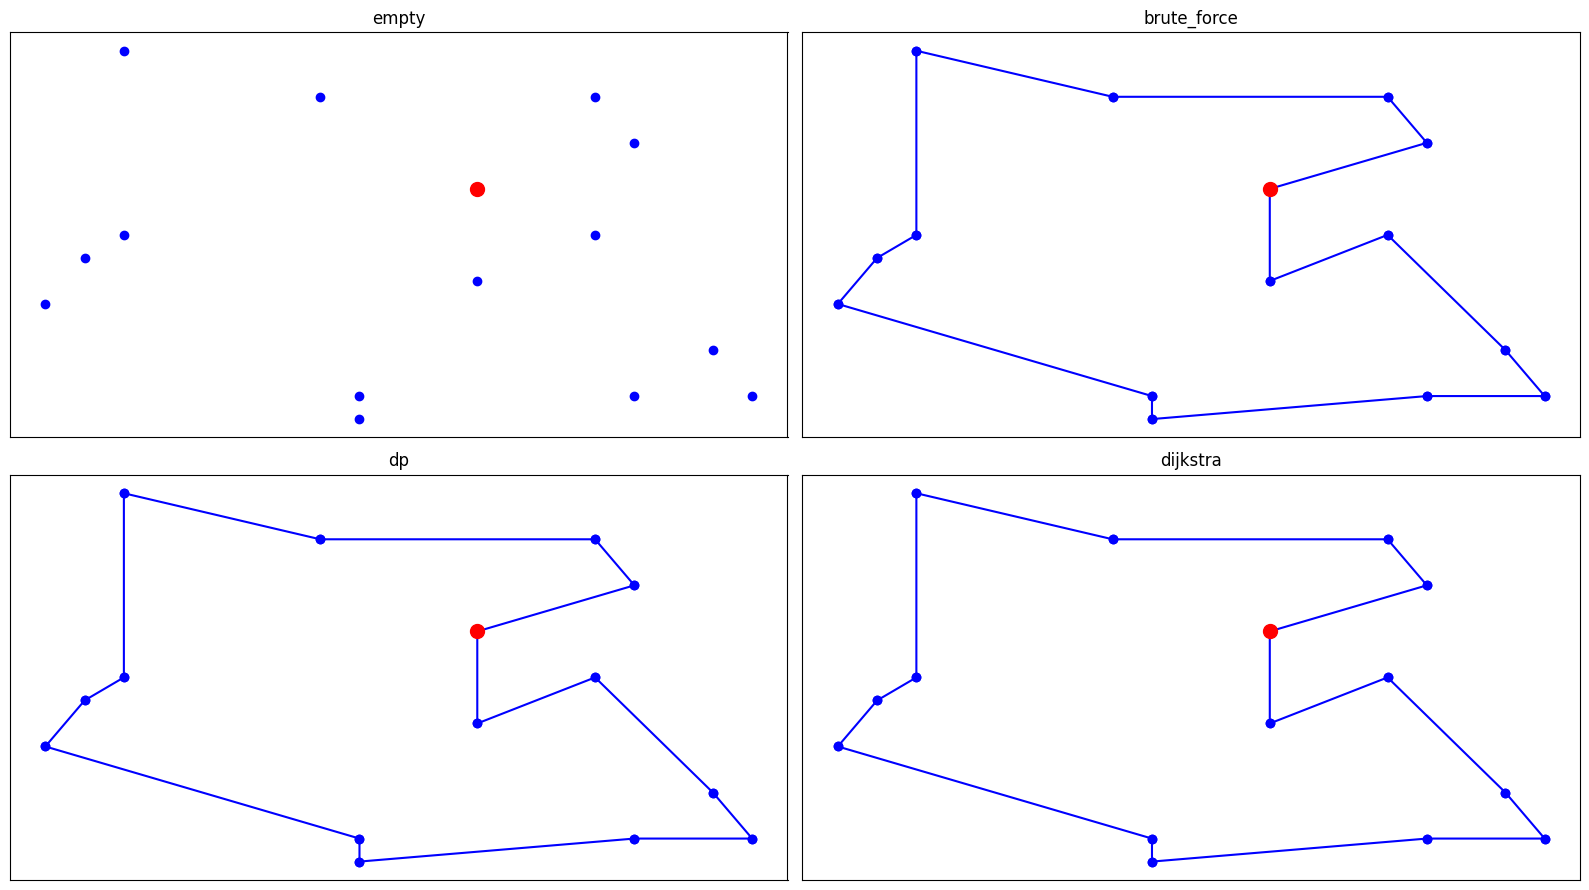

In [9]:
canvas = {}
canvas["empty"] = []
N = 15
for small_tsp_solver in brute_force, dp, dijkstra:
    _, route = dp(list(range(N)), distance_matrix)
    canvas[f"{str(small_tsp_solver).split()[1]}"] = [[0] + list(route) + [0]]
    
plot(canvas, locations[:N], 2, 2)

In [10]:
number_of_locations = 100
locations = [(randint(0, 20), randint(0, 20)) for _ in range(number_of_locations)]
distance_matrix = [
    [dist(locations[i], locations[j]) for i in range(number_of_locations)]
    for j in range(number_of_locations)
]

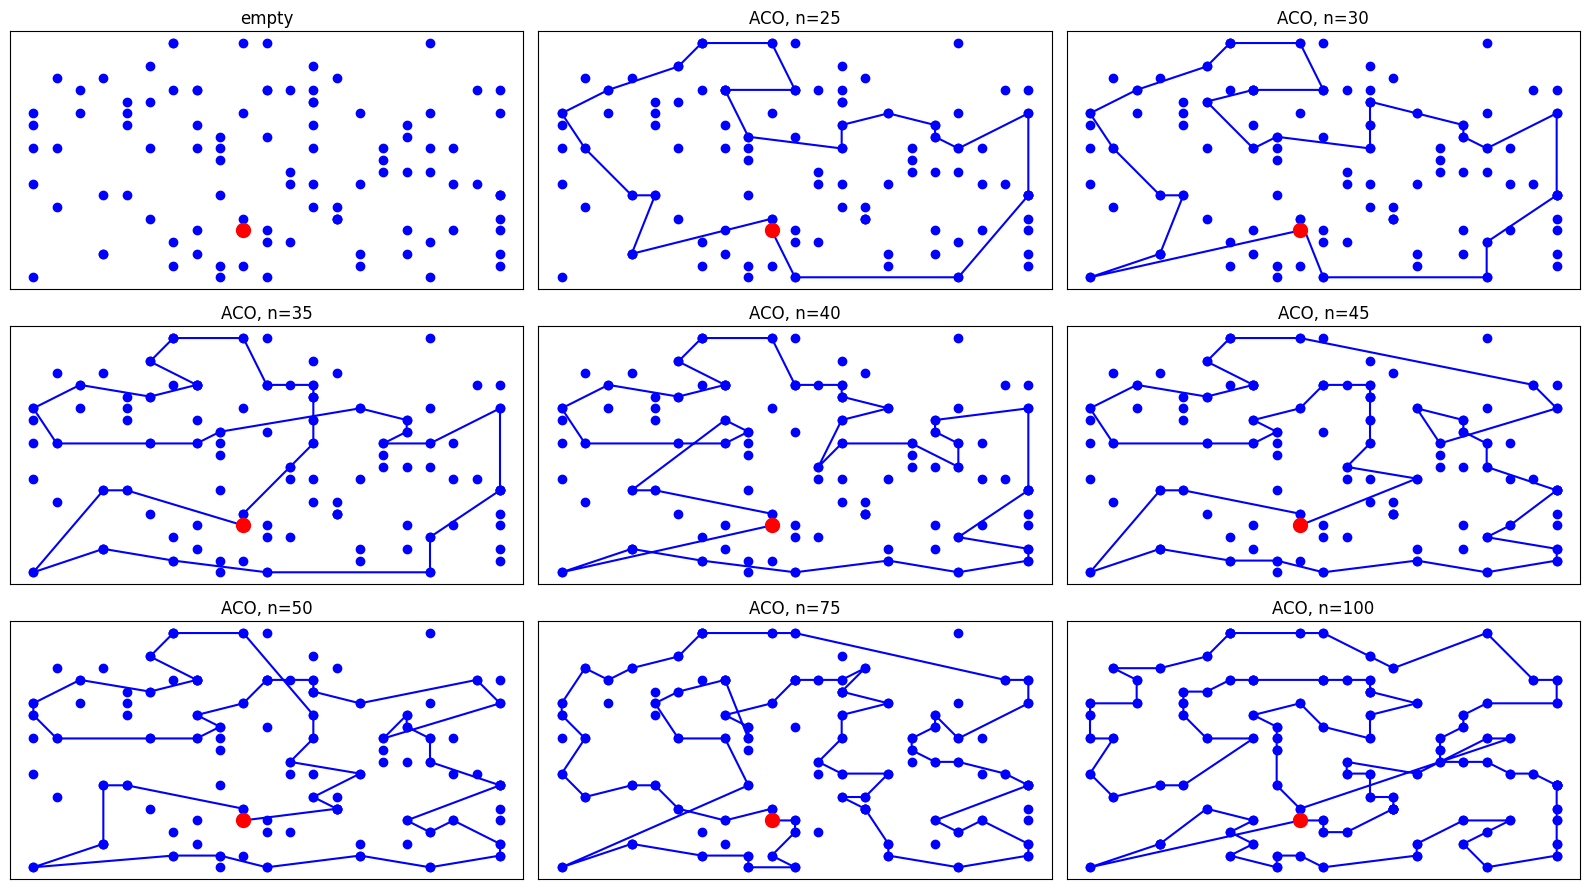

In [11]:
canvas = {}
canvas["empty"] = []
TSP_CONFIG = {
    "TSP_TIME_LIMIT": 15,
    "TSP_ALPHA": 3,
    "TSP_BETA": 3,
    "TSP_EVAPORATION": 0.3,
    "TSP_ANTS": 250,
    "TSP_INITIAL_PHEROMONE": 1,
}
for n in 25, 30, 35, 40, 45, 50, 75, 100:
    _, route = ACO(list(range(n)), distance_matrix, TSP_CONFIG)
    canvas[f"ACO, n={n}"] = [[0] + list(route) + [0]]

plot(canvas, locations[:100], 3, 3)